# Replicating Gniadecka et al.'s paper

In [2]:
import scipy.io as scio
import numpy as np 
import torch
import torch.nn as nn
import tqdm
from ipynb.fs.full.Gniadecka_functions import first_derivative_bl_removal, dim_red_PCA, train_model, test_model

#### CNN

In [105]:
class CNN2D(nn.Module):
    def __init__(self,output_size):
        super(CNN2D, self).__init__()
        self.conv1 = torch.nn.Conv2d(200,100,kernel_size=1,padding='same') 
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(2, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(100,100,kernel_size=1,padding='same') 
        self.relu2 = torch.nn.ReLU()

        self.flat = torch.nn.Flatten(1)
        self.drop = torch.nn.Dropout(p=0.3)

        self.fc1 = torch.nn.Linear(400, 100)
        self.relu3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(100, 2)
        self.softmax = torch.nn.Softmax(dim=1)  
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.conv2(output)
        output = self.relu2(output)
    
        output = self.flat(output)
        output = self.drop(output)
        
        output = self.fc1(output)
        output = self.relu3(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output
    
def train_model(model, data, target, learning_rate=0.1, num_epochs=50):
    size = target.shape[0]
            
    y = []
    for i in range(size):
            for j in range(size):
                    y.append(target[i,j])
    
    # Reshape data
    X = data.reshape(size,size,1,-1)
    tensor_X = torch.Tensor(X)
    tensor_y = torch.Tensor(y).long()

    print(tensor_X.shape, tensor_y.shape)
    dataset = torch.utils.data.TensorDataset(tensor_X, tensor_y)

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=None,
            sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(dataset), batch_size=30000, drop_last=False))

    # Train model
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model.train();

    loss_history = []
    for _ in tqdm.trange(num_epochs):
            for _, (inputs, targets) in enumerate(data_loader):
                    optimizer.zero_grad()
                    y_pred = model(inputs)
                    loss = criterion(y_pred, targets)
                    loss.backward()
                    optimizer.step()
                    loss_history.append(loss.item())
    
    return model
    
def test_model(model, data, size=200):
    X = data.reshape(data.shape[0],1,-1)
    tensor_X = torch.Tensor(X)
    
    # Evaluate model
    model.eval();
    y_pred = model(tensor_X) 

    results = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            index = i*size + j
            array = y_pred[i].detach().numpy()
            index = np.argmax(array)
            results[i,j] = index 
            
    return results

### Workflow

In [15]:
### DATA ###
tissue3 = scio.loadmat('../Data/tissue3_1.mat')
tissue6 = scio.loadmat('../Data/tissue6.mat')
tissue30 = scio.loadmat('../Data/tissue30.mat')
tissue31 = scio.loadmat('../Data/tissue31.mat')
tissue34_1 = scio.loadmat('../Data/tissue34_1.mat')
tissue34_2 = scio.loadmat('../Data/tissue34_2.mat')
tissue36 = scio.loadmat('../Data/tissue36.mat')
tissue37 = scio.loadmat('../Data/tissue37.mat')
tissue39_1 = scio.loadmat('../Data/tissue39_1.mat')

### DATA ###
tissue4 = scio.loadmat('../Data/tissue4.mat')
tissue5 = scio.loadmat('../Data/tissue5.mat')
tissue9 = scio.loadmat('../Data/tissue9.mat')
tissue10 = scio.loadmat('../Data/tissue10.mat')
tissue14 = scio.loadmat('../Data/tissue14.mat')
tissue32 = scio.loadmat('../Data/tissue32.mat')
tissue33 = scio.loadmat('../Data/tissue33.mat')
tissue35 = scio.loadmat('../Data/tissue35.mat')
tissue40 = scio.loadmat('../Data/tissue40.mat')

calibration = scio.loadmat('../Data/cal_14.mat')
x = calibration['Cal'][0][0][0]
x = [item for sublist in x for item in sublist]

In [ ]:
for key, value in tissue33.items():
    print(key)

In [20]:
bcc_tissue_data = [tissue3,tissue6,tissue30,tissue31,tissue34_1,tissue34_2,tissue36,tissue37,tissue39_1]
bcc_tissue_names = ['map_t3','map_t6','map_t30','map_t31','map_t34_1_c','map_t34_2_c','map_t36','map_t37','map_t39_1']
bcc_tissue = []

count = 0
for item in bcc_tissue_data:
    t_map = item[bcc_tissue_names[count]]
    bcc_tissue.append(t_map)
    count += 1
    
healthy_tissue_data = [tissue4,tissue5,tissue9,tissue10,tissue14,tissue32,tissue33,tissue35,tissue40]
healthy_tissue_names = ['map_t4','map_t5_1','map_t9_1','map_t10','map_t14','map_t32','map_t33_c_2','map_t35','map_t40']
healthy_tissue = []

count = 0
for item in healthy_tissue_data:
    t_map = item[healthy_tissue_names[count]]
    healthy_tissue.append(t_map)
    count += 1

In [27]:
### Remove baseline from all spectra ###
all_bcc     = []
all_healthy = []

for n in range(9):
    bcc_image     = np.zeros((40000,1024))
    healhty_image = np.zeros((40000,1024))
    
    for i in range(200):
        for j in range(200):
            index = i*200 + j
            
            bcc_signal     = bcc_tissue[n][i][j]
            healthy_signal = healthy_tissue[n][i][j]
            
            bcc_res,     _ = first_derivative_bl_removal(x,bcc_signal)
            healthy_res, _ = first_derivative_bl_removal(x,healthy_signal)
            
            bcc_image[index,:]     = bcc_res
            healhty_image[index,:] = healthy_res
    
    all_bcc.append(bcc_image)
    all_healthy.append(healhty_image)

IndexError: index 100 is out of bounds for axis 0 with size 100

In [20]:
### Perform PCA dimensionality reduction ###
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

norm_data = normalize(data)

pca = PCA(n_components=200) 
pca.fit(norm_data)
transformed = pca.transform(norm_data)

In [110]:
### Create 1D-CNN model ###
model = CNN1D(2)

In [107]:
### Train model ###
train_model(model, reduced_D, bcc)



In [ ]:
### Test model ###
approximation = test_model(model, reduced_D)

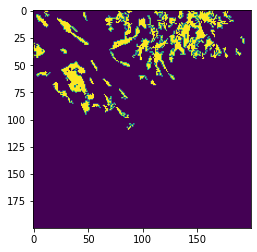

In [109]:
import matplotlib.pyplot as plt
plt.imshow(bcc)
